In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.sixb.preselection
module

/store/user/ekoenig/6BAnalysis/NTuples/2018/preselection
   Run2_UL

In [4]:
ttbar = ObjIter([Tree(module.Run2_UL18.TTJets)])
qcd = ObjIter([Tree(module.Run2_UL18.QCD_B_List)])

100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


In [5]:
ttbar[0].is_signal = True

In [6]:
leading_6_in_pt = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_pt, axis=1) < 6)
ttbar = ttbar.apply(leading_6_in_pt)
qcd = qcd.apply(leading_6_in_pt)

In [7]:
from utils.classUtils.Feynman import Feynman

In [8]:
x_tt_wb_6b = Feynman('x').decays(
    Feynman('t').decays(
        Feynman('b').decays('j'),
        Feynman('w').decays('j','j')
    ),
    
    Feynman('t').decays(
        Feynman('b').decays('j'),
        Feynman('w').decays('j','j')
    )
)

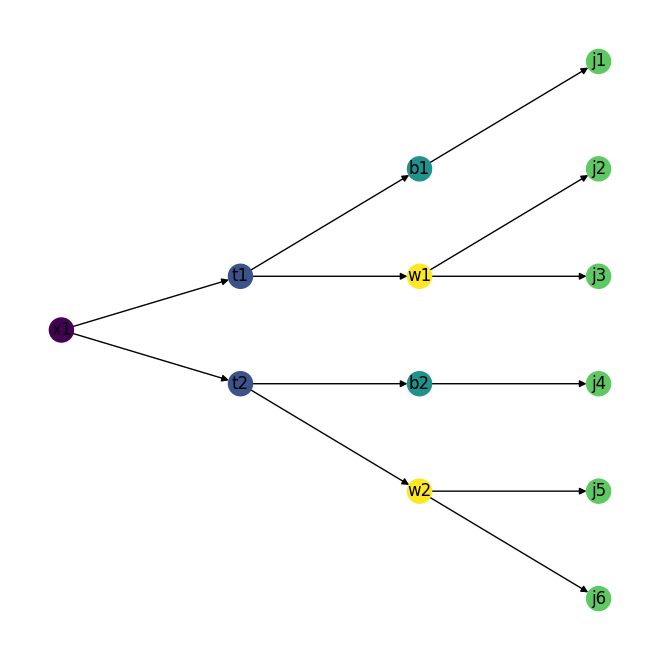

In [9]:
x_tt_wb_6b.draw_diagram()

In [10]:
ttbar_combs = ak.from_regular(np.array(x_tt_wb_6b.get_finalestate_permutations()))

In [11]:
def reconstruct_W_mass_diff(jet_p4, comb):
    wj1 = jet_p4[:,comb[1::3]]
    wj2 = jet_p4[:,comb[2::3]]
    w_p4 = wj1 + wj2
    return np.abs(w_p4.m[:,0]-w_p4.m[:,1])

In [12]:
def reconstruct_W_mass(jet_p4, comb):
    wj1 = jet_p4[:,comb[1::3]]
    wj2 = jet_p4[:,comb[2::3]]
    w_p4 = wj1 + wj2
    return ak.sum( (w_p4.m-80)**2, axis=1 )

In [20]:
def reconstruct_W_mass_near_b(jet_p4, comb):
    b_p4  = jet_p4[:,comb[::3]]
    wj1 = jet_p4[:,comb[1::3]]
    wj2 = jet_p4[:,comb[2::3]]
    w_p4 = wj1 + wj2

    wb_dr2 = ak.sum(calc_dr(b_p4.eta, b_p4.phi, w_p4.eta, w_p4.phi)**2,axis=1)
    w_dm = ak.sum( ( (w_p4.m-80) )**2, axis=1 )
    return np.sqrt(wb_dr2 + w_dm**2)


In [21]:
def reconstruct_ttbar(jet_p4, comb):
    b_p4  = jet_p4[comb[:,::3]]
    wj1 = jet_p4[comb[:,1::3]]
    wj2 = jet_p4[comb[:,2::3]]
    w_p4 = wj1 + wj2
    t_p4 = b_p4 + w_p4

    return dict(
        **{
            f't_{field}':getattr(t_p4,field)
            for field in ('pt','m','eta','phi')
        },
        **{
            f'W_{field}':getattr(w_p4,field)
            for field in ('pt','m','eta','phi')
        },
        **{
            f'b_{field}':getattr(b_p4,field)
            for field in ('pt','m','eta','phi','btag')
        },
    )

In [22]:
def select_ttbar(t):
    jet_p4 = build_p4(t, prefix='jet', extra=['btag'])
    # reco_score = ak_stack([ reconstruct_W_mass(jet_p4, comb) for comb in tqdm(ttbar_combs)], axis=1)
    reco_score = ak_stack([ reconstruct_W_mass_near_b(jet_p4, comb) for comb in tqdm(ttbar_combs)], axis=1)
    # reco_score = ak_stack([ reconstruct_W_mass(jet_p4, comb) for comb in tqdm(ttbar_combs)], axis=1)

    best_comb = ttbar_combs[ak.argmin(reco_score,axis=1)]
    t.extend(**reconstruct_ttbar(jet_p4, best_comb))

    

In [23]:
(ttbar+qcd).apply(select_ttbar)

100%|██████████| 90/90 [02:25<00:00,  1.62s/it]


[None, None]

100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


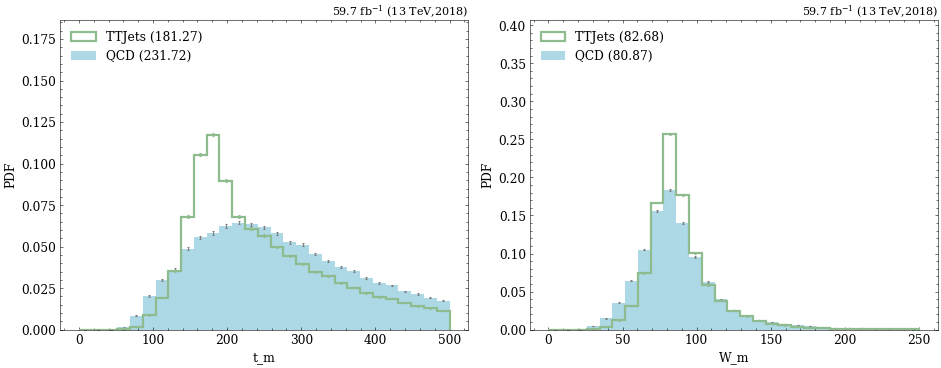

In [27]:
study.quick(
    ttbar+qcd,
    efficiency=True,
    varlist=['t_m','W_m'],
    binlist=[(0,500,30),(0,250,30)],
    h_fit='gaussian',h_fit_peak=True,h_label_stat='{fit.mu:0.2f}',
    legend=True,
)

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


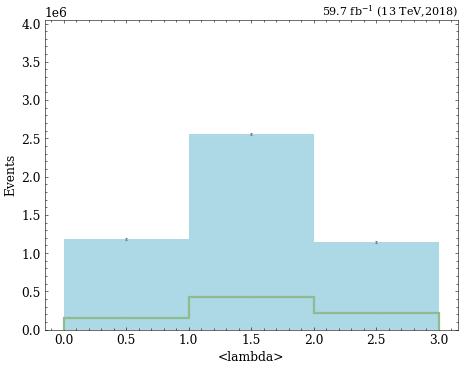

In [25]:
study.quick(
    ttbar+qcd,
    varlist=[lambda t : ak.sum(t.b_btag>jet_btagWP[1],axis=1)],
)

100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


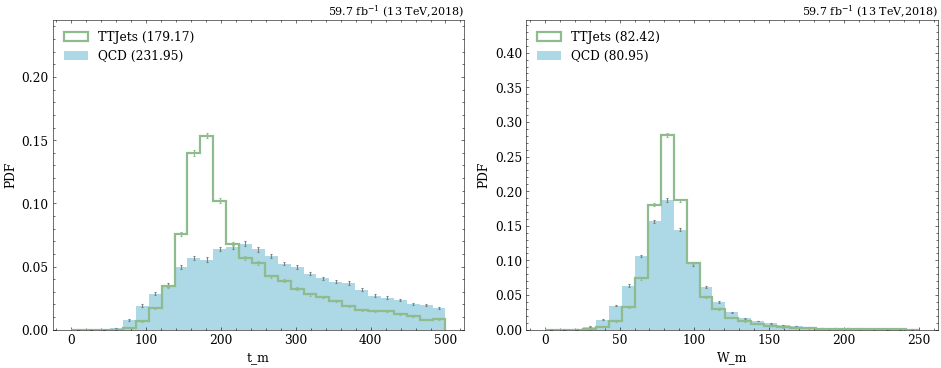

In [28]:
study.quick(
    ttbar+qcd,
    efficiency=True,
    masks=lambda t : ak.sum(t.b_btag>jet_btagWP[1],axis=1) == 2,
    varlist=['t_m','W_m'],
    binlist=[(0,500,30),(0,250,30)],
    h_fit='gaussian',h_fit_peak=True,h_label_stat='{fit.mu:0.2f}',
    legend=True,
)